# Checking your fitting results

In the previous notebooks we've shown how ion current models can be fit with Myokit & PINTS.

In this notebook, we look at the results and discuss ways to tell if they're any good.

## Checking your optimisation set-up with synthetic data studies

The first thing to do, before even runnig your fits, is to test out your methods on _synthetic data_, generated from the model you're going to fit with.
If you've followed the notebooks so far, you should have seen plenty of examples of this.

If the synthetic study fails to find the right result, it's obvious your methods are going to struggle on the harder real-world problem.
But there are other ways in which synthetic data helps:

- Synthetic studies can be a great tool to configure or tweak your set-up. For example, we saw in earlier notebooks how they can be used to work out appropriate ODE solver tolerances.
- Experimenting with different noise settings will help set expectations for how well the method will perform on real data.
- Good performance on a synthetic problem can give you (and others!) confidence that the applied methodology is sound. This is particularly relevant when the real data results are not as good as hoped, or are hard to interpret.

### Switching to real data

Lots of problems can arise when you switch from synthetic to real data.
Two common ones are:

**Contamination of input and output signals**.   
For example _voltage-clamp artefacts_ may be visible in the recorded currents, along with _leak_ current and even _endogeneous currents_: other native transmembrane currents that were active during the recording.
It is important to remember that inputs can be contaminated as well: even with excellent voltage-clamping the membrane will not be exactly at the voltage set by the protocol.
More interestingly, the quality of the voltage-clamp depends on the transmembrane currents.
See for example [Lei et al. 2020](https://doi.org/10.1098/rsta.2019.0348) and [Montnach et al. 2020](https://doi.org/10.1038/s41598-021-82077-8).

An idea explored in the Lei et al. paper is to build a more complex noise model, that incorporates these forms of contamination.
But there is a trade-off involved here, as a more complex noise model invariably requires more parameters to be fitted.
   
**Model misspecification**.
It may be possible that there is no set of parameters that provides a good fit.
In statistics, this is sometimes called "model misspecification", although a simpler way to say it is that the model is _wrong_.
This isn't as bad as it sounds though.
In the words of Richard Fitzhugh "A model is something simple made by a scientist to help [them] understand something complicated".
Simplification invariable introduces some degree of "wrongness", so again there is a trade-off between increasing the complexity (and parameter count) of the model, and keeping it simple (but solvable).

Figuring out whether it's the model or the data that is at fault can be difficult, and dealing with these problems is an active area of research.
However, unless you have strong results on a synthetic data study before starting, it is impossible to say whether these issues are at play or if the methodology is at fault.

## Checking your real-data results with repeated fits

Once you've convinced yourself that the fitting software works _in silico_, you might run a few first optimisations to check that you get reasonable fits.
In many cases, you will still see quite some residual error at this point (e.g. due to experimental imperfections or model misspecification), and so the question will arise whether the results you got are the best ones possible.
In other words, have you found the _global optimum_?

Global optimisation is a notoriously hard problem, and there is no real answer to this question other than exploring the error surface really really well. (You can of course do clever things if you have information about e.g. the smoothness of the surface, which might reduce the amount of exploration you need to do).
One of the simplest methods to build a global optimiser is to use a _multistart_ strategy, e.g. to run repeated fits from randomly sampled starting points.

But even with a method like CMA-ES which already does some global exploration, there are advantages to a repeated fits approach because it can tell you a lot about the _robustness_ of your fitting set-up:
With an easy problem and a good optimiser, we'd expect each repeat to find the same result, regardless of the starting point.
With a harder problem, we'd expect the optimiser to fail a certain number of times, but still to get the right result _most_ of the time.
If we find a different result every time, this is a good reason to treat each result with suspicion.
But uf we can satisfy ourselves that the optimiser returns a highly similar point on most runs, and that this point has a better score than any other point, then we can feel more confident that we have done a good job.

### Exploring obtained errors (or scores, or likelihoods)

To explore these ideas, we'll use the result-loading methods from the previous notebook and load some results from [Clerx et al. 2019](https://doi.org/10.1016/j.bpj.2019.08.001).
In this paper we applied different fitting methods to a data set from [Beattie et al.](https://doi.org/10.1113/JP276068).
The results we'll load here are for "method 2" and "method 3", applied "cell 1"s data (see the paper for details).

We start by importing [library.py](library.py) and calling the `load` method we made earlier.
As its docstring explains, this will gather data from different files and return two numpy arrays: one containing parameter sets and one containing information about the run.

In [1]:
import numpy as np
from library import load

parameters2, info2 = load('resources/four-ways/method-2/cell-1-fit-2-run.txt')
parameters3, info3 = load('resources/four-ways/method-3/cell-1-fit-3-run.txt')

cell-1-fit-2-run resources/four-ways/method-2/cell-1-fit-2-run-*.txt
cell-1-fit-3-run resources/four-ways/method-3/cell-1-fit-3-run-*.txt


For each method, this data contains parameter sets and information about 50 repeats, each from a random starting point:

In [2]:
print(len(parameters2), len(parameters3))

50 50


Checking the docstring for `load` again, we see that the entries in `info` are structured as `(run, error, time, iterations, evaluations)`, and that they are ordered from best (lowest error) to worst.

So a first thing we can do is inspect the errors in each run:

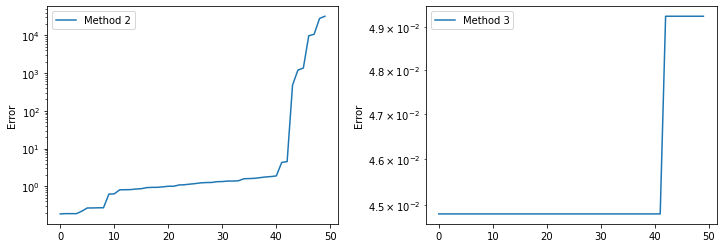

In [3]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)

ax = fig.add_subplot(1, 2, 1)
ax.set_ylabel('Error')
ax.set_yscale('log')
ax.plot(info2[:, 1], label='Method 2')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.set_ylabel('Error')
ax.set_yscale('log')
ax.plot(info3[:, 1], label='Method 3')
ax.legend()

plt.show()

Because the methods use a different error function, _the absolute magnitudes don't tell us much_.
But we can see that the errors are distributed very differently, with method 2 errors showing much more variation.

### How many fits had low errors?

We'd like to see how many results had a low error, but we don't really know what magnitude a "low" error would be (although we might get some idea from playing with synthetic data).
What we can do instead is count how many results were close to the best result we found.
For example, we can calculate a relative error $r_i$ for each repeat $i$:

$$ r_i = \frac{e_i - e_0}{e_0} \cdot 100\% $$

where $e_i$ is the error in repeat $i$ and $e_0$ is the error in the best repeat.

We can then count how many repeats had an $r_i$ below some arbitrary threshold:

In [4]:
# Get errors for methods 2 and 3
e2 = info2[:, 1]
e3 = info3[:, 1]

# Get errors relative to best (in percent)
r2 = 100 * (e2 - e2[0]) / e2[0]
r3 = 100 * (e3 - e3[0]) / e3[0]

# We can use "r2 < 1" to get an array of booleans, where True indicates
# that the relative error was less than 1%.
# We can then use this boolean array as a selector, to keep only the
# elements in r2 where r2 < 1. The code for this is r2[r2 < 1].
# Finally, we can count how many entries are in this set:

nr_best2 = len(r2[r2 < 1])
nr_best3 = len(r3[r3 < 1])
print('Number of points a relative error less than <1%:', nr_best2)
print('Number of points a relative error less than <1%:', nr_best3)

Number of points a relative error less than <1%: 1
Number of points a relative error less than <1%: 42


Things are not looking good for Method 2!

But the words "arbitrary threshold" don't sound very scientific.
Maybe we should investigate that?

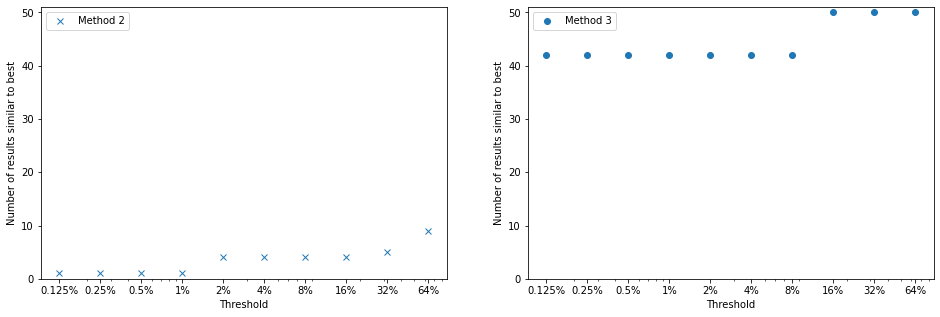

In [5]:
# Loop over thresholds, defined as percentages
x = [0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64]
y2, y3 = [], []
for threshold in x:
    # Count how many points are withing `threshold` % of best
    y2.append(len(r2[r2 < threshold]))
    y3.append(len(r3[r3 < threshold]))

# Plot
fig = plt.figure(figsize=[16, 5])

ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel('Threshold')
ax.set_ylabel('Number of results similar to best')
ax.set_xscale('log')
ax.set_xticks(x)
ax.set_xticklabels([str(i) + '%' for i in x])
ax.set_ylim(0, 1 + len(e2))
ax.plot(x, y2, 'x', label='Method 2')
ax.legend(loc='upper left')

ax = fig.add_subplot(1, 2, 2)
ax.set_xlabel('Threshold')
ax.set_ylabel('Number of results similar to best')
ax.set_xscale('log')
ax.set_xticks(x)
ax.set_xticklabels([str(i) + '%' for i in x])
ax.set_ylim(0, 1 + len(e3))
ax.plot(x, y3, 'o', label='Method 3')
ax.legend(loc='upper left')

plt.show()  

This is interesting, as it shows us that Method 4 errors are similar to a much tighter threshold than results from Method 2, for which we find a unique best result with any threshold below approximately 2%.

If we're in a good mood, we might decide to be a little bit less stringent and use a 2% cut-off:

In [6]:
# Count points near the best point
nr_best2 = len(r2[r2 < 2])
nr_best3 = len(r3[r3 < 2])
print('Number of points a relative error less than <2%:', nr_best2)
print('Number of points a relative error less than <2%:', nr_best3)

Number of points a relative error less than <2%: 4
Number of points a relative error less than <2%: 42


With this cut-off, we find a small group of "best results" with Method 2, and a much larger group with Method 4.

This suggests that Method 4 is quite consistent, although it's still possible that we've found very different parameter sets `x` that just happen to have a similar error `f(x)`!

To check if this is the case, we turn to the obtained parameter values.

### Inspecting the obtained parameter sets

We start by plotting _all_ obtained parameter sets on the "boundary plots" we created earlier:

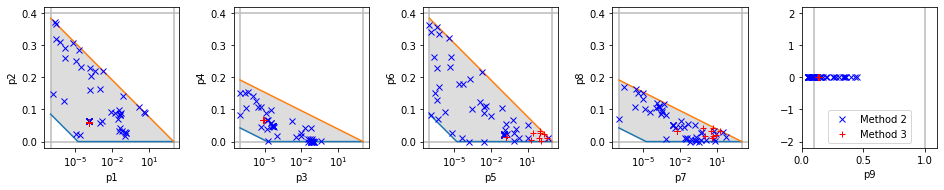

In [7]:
from library import multivariate_boundary_plot, boundary_plot_point

# Create a plot and show all results for method 2 and method 3
axes = multivariate_boundary_plot(a_log=True)
boundary_plot_point(axes, parameters2, 'bx', label='Method 2')
boundary_plot_point(axes, parameters3, 'r+', label='Method 3')
axes[-1].legend()
plt.show()

This shows lots of variation for Method 2, but only a little variation in Method 3 (and mostly in the inactivation parameters p5 to p8).

Next, we remove all parameter sets for which the relative error was above our threshold, and plot again:

4 42


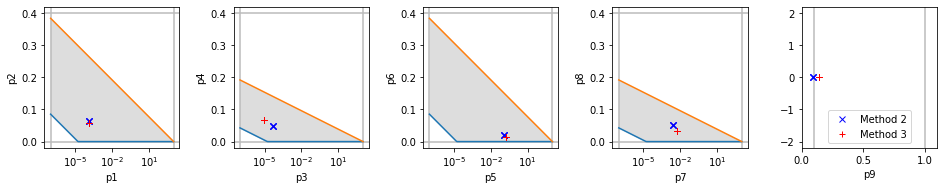

In [8]:
# Select only parameters with a score similar to the best score obtained, using 2% cut-off
p_rbest2 = parameters2[r2 < 2]
p_rbest3 = parameters3[r3 < 2]
print(len(p_rbest2), len(p_rbest3))

# Create a plot and show selected results for method 2 and method 3
axes = multivariate_boundary_plot(a_log=True)
boundary_plot_point(axes, p_rbest2, 'bx', label='Method 2')
boundary_plot_point(axes, p_rbest3, 'r+', label='Method 3')
axes[-1].legend()
plt.show()

This seems to have removed the variation for Method 3, although if we squint there's some bluriness detectable for Method 2.

To have a better look, we switch to plotting each parameter seperately, and again look at relative errors:

$$ \frac{p_{i,j} - p_{0,j}}{p_{0,j}} \cdot 100\% $$

where $j$ indicates the parameter and $i$ indicates the repeat (still ordered so that repeat 0 had the best score).


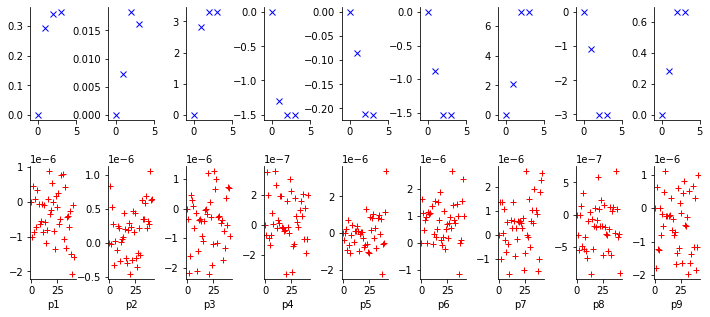

In [9]:
fig = plt.figure(figsize=(12, 5))
grid = plt.GridSpec(2, 9, wspace=0.7, hspace=0.4)

for i in range(9):
    ax = fig.add_subplot(grid[0, i])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    y = 100 * (p_rbest2[:, i] / p_rbest2[0, i] - 1)
    ax.plot(y, 'bx')
    ax.set_xlim(-1, 1 + len(y))

    ax = fig.add_subplot(grid[1, i])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('p' + str(1 + i))
    y = 100 * (p_rbest3[:, i] / p_rbest3[0, i] - 1)
    ax.plot(y, 'r+')
    ax.set_xlim(-1, 1 + len(y))
   
plt.show()

This shows the the _relative_ variability in Method 2's "best results" was quite high, up to about 7% in $p_7$.
At the same time, the relative variability in the Method 3 results was in the order of $10^{-6}%$.
To be more precise:

In [10]:
print('Max relative variation in Method 2 results: ')
print(np.max(100 * (p_rbest2 / p_rbest2[0] - 1)))

Max relative variation in Method 2 results: 
6.952446643243926


In [11]:
print('Max relative variation in Method 3 results: ')
print(np.max(100 * (p_rbest3 / p_rbest3[0] - 1)))

Max relative variation in Method 3 results: 
3.3965581014427926e-06


### Combined parameter and error analysis

If we're less interested in _which parameter_ varied the most, we can also plot the maximum variation _in any parameter_ for each run:

$$ d_{i} = \max_j \frac{|p_{i, j} - p_{0, j}|}{p_{0, j}} \cdot 100\% $$

We can then plot this, along with the error information (including all results, good or bad):

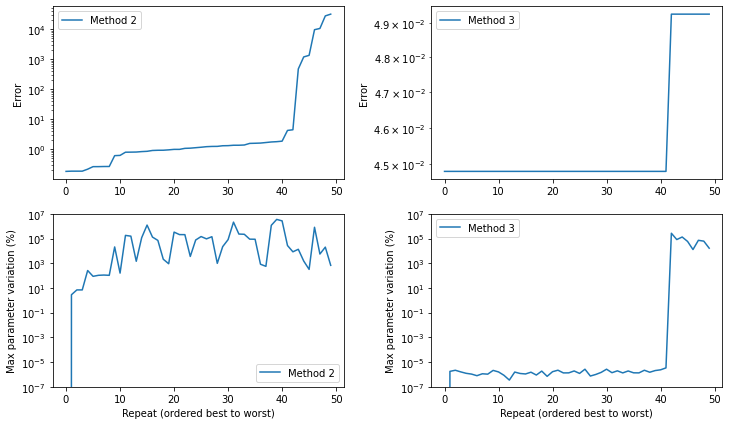

In [12]:
# Get maximum errors in parameter sets:
d2 = 100 * np.max(np.abs(parameters2 - parameters2[0]) / parameters2[0], axis=1)
d3 = 100 * np.max(np.abs(parameters3 - parameters3[0]) / parameters3[0], axis=1)

# Plot, along with scores
fig = plt.figure(figsize=(12, 7))
fig.subplots_adjust(wspace=0.3)

ax = fig.add_subplot(2, 2, 1)
ax.set_ylabel('Error')
ax.set_yscale('log')
ax.plot(info2[:, 1], label='Method 2')
ax.legend()

ax = fig.add_subplot(2, 2, 2)
ax.set_ylabel('Error')
ax.set_yscale('log')
ax.plot(info3[:, 1], label='Method 3')
ax.legend()

ylim = 1e-7, 1e7
ax = fig.add_subplot(2, 2, 3)
ax.set_xlabel('Repeat (ordered best to worst)')
ax.set_ylabel('Max parameter variation (%)')
ax.set_yscale('log')
ax.plot(d2, label='Method 2')
ax.set_ylim(*ylim)
ax.legend()

ax = fig.add_subplot(2, 2, 4)
ax.set_xlabel('Repeat (ordered best to worst)')
ax.set_ylabel('Max parameter variation (%)')
ax.set_yscale('log')
ax.plot(d3, label='Method 3')
ax.set_ylim(*ylim)
ax.legend()

plt.show()

For Method 2, we see a very small number of points with a fitting error similar to the best error obtained.
A few nearby points have a similar (but greater) error, and as soon as the error rises more the points start to jump around the parameter space.

For method 3, we see a group of with identical low fitting errors which form a tight cluster in parameter space (relative difference < 1e-5%).
A few points have a larger error, and these are spread out over the parameter space.

As before, we can define cut-offs and count the number of results in each group:

In [13]:
# Get errors
e2 = info2[:, 1]
e3 = info3[:, 1]

# Get errors relative to best (in percent)
r2 = 100 * (e2 - e2[0]) / e2[0]
r3 = 100 * (e3 - e3[0]) / e3[0]

# Count number of points with error within 2% of best
nr_best2 = len(r2[r2 < 2])
nr_best3 = len(r3[r3 < 2])

print('Number of results with error within 2% of best obtained:')
print('Method 2: ' + str(nr_best2) + ' out of ' + str(len(e2)))
print('Method 3: ' + str(nr_best3) + ' out of ' + str(len(e3)))

# Get parameters with lowest errors
p_rbest2 = parameters2[r2 < 2]
p_rbest3 = parameters3[r3 < 2]

# Calculate relative error in each parameter, but only for low-error points
d_rbest2 = 100 * np.max(np.abs(p_rbest2 - p_rbest2[0]) / p_rbest2[0], axis=1)
d_rbest3 = 100 * np.max(np.abs(p_rbest3 - p_rbest3[0]) / p_rbest3[0], axis=1)

# Count number of low-error points that are within 1% of the best parameter set
n2 = len(d_rbest2[d_rbest2 < 1])
n3 = len(d_rbest3[d_rbest3 < 1])

print('Number of those results with less than 1% max parameter variation')
print('Method 2: ' + str(n2))
print('Method 3: ' + str(n3))

Number of results with error within 2% of best obtained:
Method 2: 4 out of 50
Method 3: 42 out of 50
Number of those results with less than 1% max parameter variation
Method 2: 1
Method 3: 42


These numbers, though a bit tricky at first, provide a very useful summary of the results.

For Method 3, 84% of results share the lowest score, and all are nearby in parameter space.
For Method 2, 8% of results are similar to the lowest score, but these show some variation in parameter space, indicating that the best possible result may not be inside this set.

## Testing the usefulness of your model: training and validation data

From the above analysis, we learn to treat results from Method 2 with suspicion.
But what have we learned about Method 3? We've seen that the method performs consistently, but the analysis cannot tell us if it has worked _correctly_.

We can, however, test if the model is _useful_: e.g. whether it makes good _predictions_.

In particular, while it is tempting to show off the "quality of fit" as proof of a good model, it is much more important that the model can produce good predictions of voltage protocols that it was never trained on.
In [machine learning terms](https://en.wikipedia.org/wiki/Training%2C_validation%2C_and_test_sets), we should carefully design our experiments to generate both a _training set_ (used to "train" the model) and a _validation set_ (used to see if its predictions are any good).

In the paper ["Sinusoidal voltage protocols for rapid characterisation of ion channel kinetics"](https://doi.org/10.1113/JP276068) by Beattie et al., training sets were created by applying either a conventional voltage-clamp step protocol (Method 2 and 3), or a sinusoidal protocol (Method 4).
An independent validation set was then created by applying an AP-waveform protocol in the same cells.

As an example, we'll show a result obtained by fitting to the sinusoidal protocol, and then a prediction on the AP protocol.

(For details of how these protocols are implemented in simulation please see the earlier tutorials.)

In [14]:
import myokit

# Load the data that was fitted to
sine_data = myokit.DataLog.load('resources/sine-wave-data/cell-1.zip')
sine_time = sine_data['time']
sine_current = sine_data['current']
del(sine_data)

# Parameters giving best fit on the sinusoidal protocol, on the data set for "Cell 1"
# (Parameters as determined in the "Four ways" paper)
parameters = [
    1.97488396293571015e-04,
    5.93926012974279674e-02,
    7.16377910328610726e-05,
    4.93357304150380954e-02,
    1.04564468668640331e-01,
    1.38042995586312549e-02,
    3.81996945050016223e-03,
    3.60390982206262936e-02,
    1.34986219156051829e-01,
]

# Load the model
model = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')

# Apply parameters
for i, p in enumerate(parameters):
    model.get('ikr.p' + str(1 + i)).set_rhs(p)

# Load the step part of the sine wave protocol
protocol = myokit.load_protocol('resources/sine-wave-steps.mmt')

# Adapt for sine waves
c = model.get('membrane')
c.get('V').set_binding(None)
vp = c.add_variable('vp')
vp.set_rhs(0)
vp.set_binding('pace')
model.get('membrane.V').set_rhs(
    'if(engine.time >= 3000.1 and engine.time < 6500.1,'
    + ' - 30'
    + ' + 54 * sin(0.007 * (engine.time - 2500.1))'
    + ' + 26 * sin(0.037 * (engine.time - 2500.1))'
    + ' + 10 * sin(0.190 * (engine.time - 2500.1))'
    + ', vp)')

# Create and run a simulation
sim = myokit.Simulation(model, protocol)

tmax = sine_time[-1] + 1
log = sim.run(tmax, log_times=sine_time)

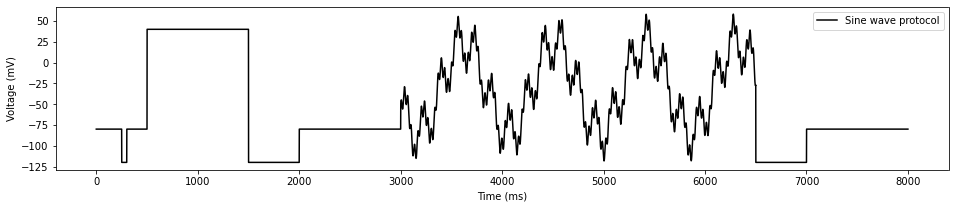

In [15]:
# Show the applied protocol
fig = plt.figure(figsize=(16, 3))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Voltage (mV)')
ax.plot(log['engine.time'], log['membrane.V'], 'k', label='Sine wave protocol')
ax.legend()
plt.show()

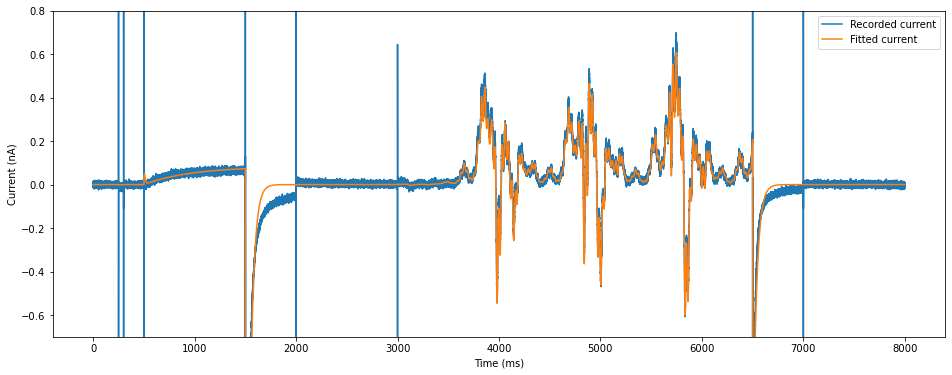

In [16]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Current (nA)')
ax.plot(sine_time, sine_current, label='Recorded current')
ax.plot(log['engine.time'], log['ikr.IKr'], label='Fitted current')
ax.legend()
ax.set_ylim(-0.7, 0.8)
plt.show()

Next, we show a _prediction_ on the AP protocol. This protocol was not used during fitting.

In [17]:
# Load the AP protocol
ap_data = myokit.DataLog.load_csv('resources/ap.csv').npview()
ap_time = ap_data['time']
ap_voltage = ap_data['voltage']

# Load the experimentally recorded validation data
ap_data = myokit.DataLog.load('resources/sine-wave-data/ap-cell-1.zip')
ap_current = ap_data['current']
del(ap_data)

# Load the model and apply the parameters
model = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')
for i, p in enumerate(parameters):
    model.get('ikr.p' + str(1 + i)).set_rhs(p)

# Create a simulation with a fixed-form protocol
sim = myokit.Simulation(model)
sim.set_fixed_form_protocol(ap_time, ap_voltage)

# Run a simulation
tmax = ap_time[-1] + 1
log = sim.run(tmax, log_times=ap_time)

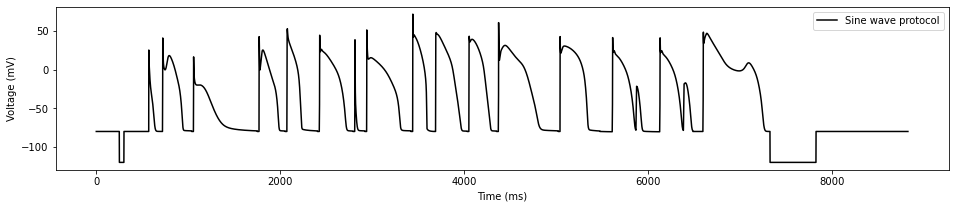

In [18]:
# Show the applied protocol
fig = plt.figure(figsize=(16, 3))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Voltage (mV)')
ax.plot(log['engine.time'], log['membrane.V'], 'k', label='Sine wave protocol')
ax.legend()
plt.show()


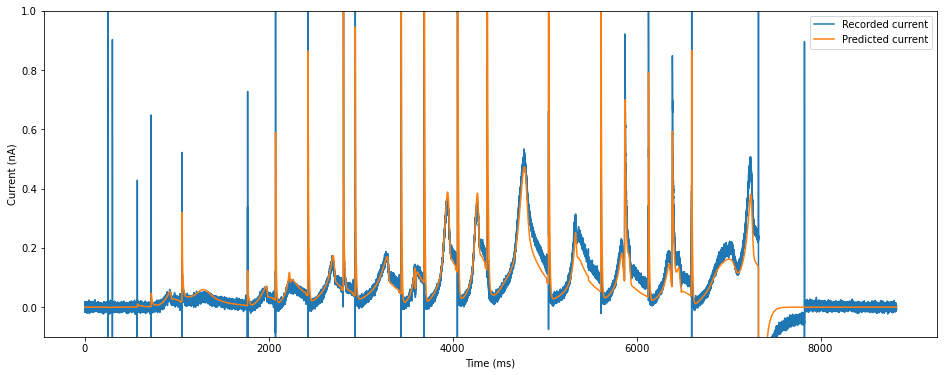

In [19]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Current (nA)')
ax.plot(ap_time, ap_current, label='Recorded current')
ax.plot(log['engine.time'], log['ikr.IKr'], label='Predicted current')
ax.legend()
ax.set_ylim(-0.1, 1)
plt.show()

Even though the fit wasn't perfect, we get very good predictions on the validation set, showing that this is a useful model!

### Three data sets?

Some machine learning studies go even further, and use three independent data sets:

1. A training set, to which models are fit.
2. A validation set, used to test the models performance. Based on these results, the method may be tweaked by the experimenter!
3. A test set, used to test the performance of the final model selected during validation.

## Summary

In this notebook, we've

1. Discussed how synthetic data studies can help us set up and debug our fitting software, although the real data may be contaminated in ways we didn't consider, and even with the best parameters our model may not fit the data perfectly.
2. Explored how a repeated-runs strategy can be used to detect potentially unreliable results.
3. Shown how an independent validation data set can be used to show a model's usefulness.

Thanks for reading!